# Biometrics a.y. 2022-2023 - FACE RECOGNITION LAB

**Face detection** is the task of localizing a face in an image or video sequence. It can be done using computer vision algorithms like "Viola and Jones" or Deep Learining techniques.

**Face recognition** is the task of classifying a face whenever it has been localized, i.e., telling who is in that face.

The workflow used in this lab experience to prepare the dataset used to train the neural network is structured as follows:
1. The Viola and Jones algorithm is used to detect the face in the image in order to isolate it
2. The faces are preprocessed and augmented in order to be able to train a more robust netowork
3. The colorspace is converted to Grayscale.
4. The dataset is ready to be used.


In [1]:
#load the required packages and check Scikit-learn version
%matplotlib inline  

import tensorflow as tf
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from tensorflow import keras
import math
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import pandas as pd
import seaborn as sn

##Section 1: Dataset CelebA-HQ

We now load the dataset [CelebA-HQ](https://www.tensorflow.org/datasets/catalog/celeb_a_hq?hl=it) and prepare the data for the experiments



In [2]:
!gdown https://drive.google.com/uc?id=1QIOsB9uVfFYXMvZ7fo8Wxgmlw1uzKl6M

Downloading...
From: https://drive.google.com/uc?id=1QIOsB9uVfFYXMvZ7fo8Wxgmlw1uzKl6M
To: /content/dataset.zip
100% 721M/721M [00:10<00:00, 66.5MB/s]


In [3]:
!unzip dataset.zip

Archive:  dataset.zip
  inflating: datasets/Y_test_sunglasses.npy  
  inflating: datasets/Y_test_glasses.npy  
  inflating: datasets/Y_test_mask.npy  
  inflating: datasets/Y_test.npy     
  inflating: datasets/Y_test_facemask.npy  
  inflating: datasets/Y_train.npy    
  inflating: datasets/X_test_facemask.npy  
  inflating: datasets/X_test_mask.npy  
  inflating: datasets/X_test_glasses.npy  
  inflating: datasets/X_test.npy     
  inflating: datasets/X_test_sunglasses.npy  
  inflating: datasets/X_train.npy    


In [4]:
X_train_path = './datasets/X_train.npy'
X_test_path = './datasets/X_test.npy'
Y_train_path = './datasets/Y_train.npy'
Y_test_path = './datasets/Y_test.npy'

In [5]:
X_train = np.load(X_train_path)
X_test = np.load(X_test_path)
Y_train = np.load(Y_train_path)
Y_test = np.load(Y_test_path)

The original dataset has been **preprocessed** and the images have been divided into training and test set and stored in the numpy files `X_train` and `X_test`. The training set has been augmented by a factor 10.
The correspondent labels are stored in the files `Y_train` and `Y_test`. 

The following table reports the association between labels and people in the dataset.

| Label | Description |
| --- | --- |
| 0 | Adam Sandler |
| 1 | Alyssa Milano |
| 2 | Bruce Willis |
| 3 | Denise Richards |
| 4 | George Clooney |
| 5 | Gwyneth Paltrow |
| 6 | Hugh Jackman |
| 7 | Jason Statham |
| 8 | Jennifer Love Hewitt |
| 9 | Lyndsay Lohan |
| 10 | Mark Ruffalo |
| 11 | Robert Downey Jr |
| 12 | Will Smith |

Let's define a usefull function

In [6]:
def plot_images(images, labels, predictions=None, class_names=None):
    assert len(images) == len(labels) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(20, 20))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        
        # Plot image.
        ax.imshow(images[i].squeeze(), cmap='gray')
        
        # Show true and predicted classes.
        if predictions is None:
            xlabel = "True: {0}".format(class_names[int(labels[i])])
        else:
            xlabel = "True: {0}, Pred: {1}".format(class_names[int(labels[i,0])], class_names[int(predictions[i].argmax())])
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

We map the labels downloaded $0,\dots, 13$ into the real name of the actors.

In [7]:
#define the classes
label_ids = {'Adam Sandler': 0, 'Alyssa Milano': 1, 'Bruce Willis': 2, 'Denise Richards': 3, 'George Clooney': 4, 'Gwyneth Paltrow': 5, 'Hugh Jackman': 6, 'Jason Statham': 7, 'Jennifer Love Hewitt': 8, 'Lindsay Lohan': 9, 'Mark Ruffalo': 10, 'Robert Downey Jr': 11, 'Will Smith': 12}

# Number of classes
num_classes = 13

Let's see some examples of the faces that we're working with...

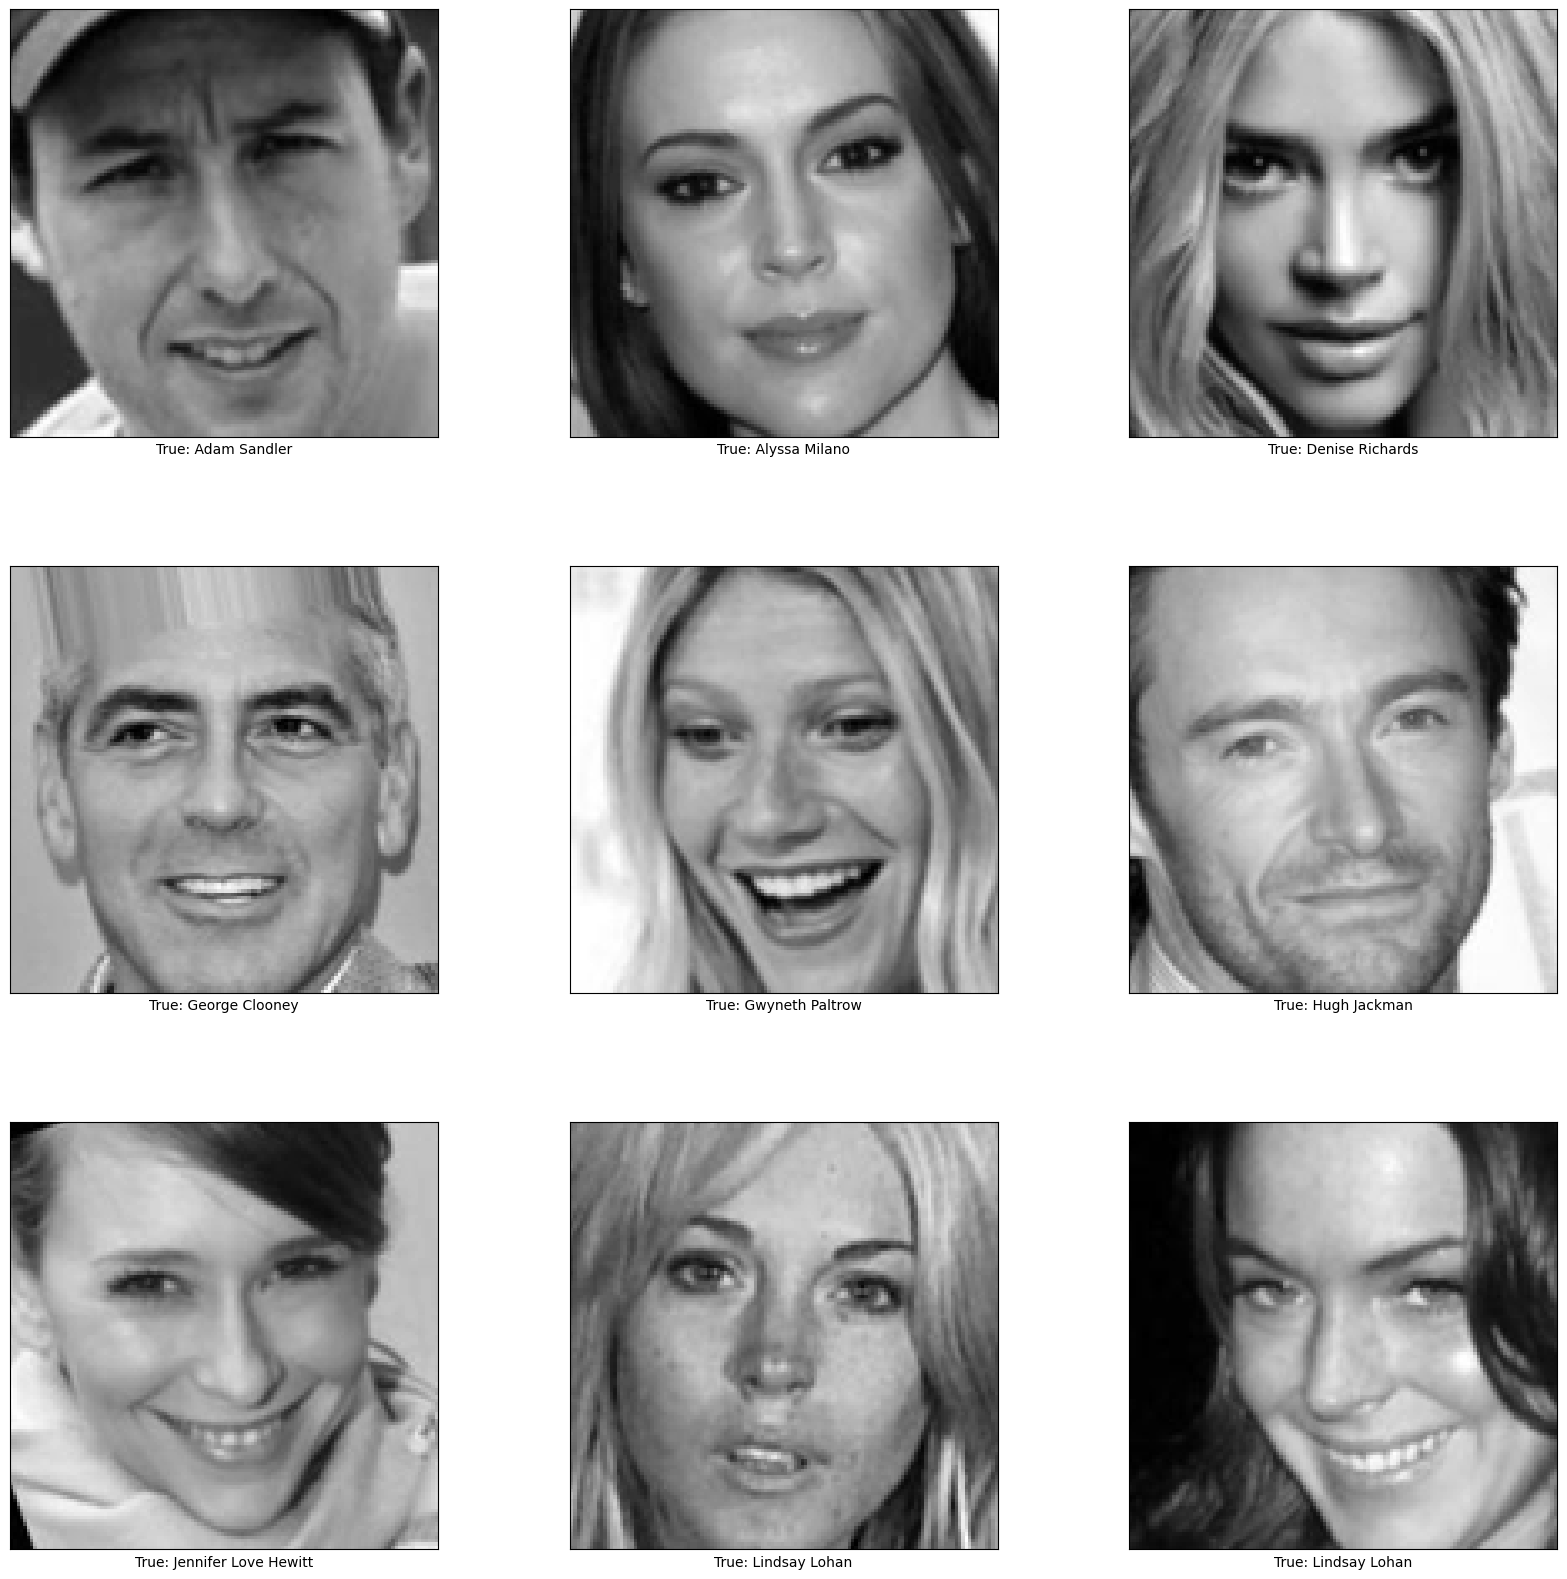

In [8]:
class_names = {value:key for key, value in label_ids.items()}
plot_images(
    X_train[[1, 3000, 6000, 9000, 12000, 15000, 18000, 21000, 24000]],
    Y_train[[1, 3000, 6000, 9000, 12000, 15000, 18000, 21000, 24000]],
    predictions=None,
    class_names=class_names
)

###TASK 1.1 - Shuffling & Normalization

Shuffling and Normalization of the data

Before feeding the neural network, the images must be normalized (with values between 0 and 1) and shuffled, together with their labels. Shuffle the images storing the results in the variables `train_labels` and `train_images`. Then normalize the images.

In [9]:
################# code here ###################
#shuffle sets using the shuffle function from sklearn (provided above)
X_train, Y_train = shuffle(X_train, Y_train, random_state=0)

train_labels = Y_train
train_images = X_train

# Normalization
train_images = train_images / 255.0
################# code here ###################

###TASK 1.2 - Model
Definition of a Simple CNN

Define a simple Convolutional neural network that learn to classify the faces of the various celebrities in the dataset.

Make sure that the network you has good performance (at least 90% validation accuracy) and that it is not overfitting (i.e. training accuracy close to validation accuracy).

When compiling the network add accuracy as one of the metrics since it will be needed later

In [10]:
################# code here ###################
# Number of samples and image dimension (images are squared)
num_samples = X_train.shape[0];
img_shape = X_train.shape[1];
################# code here ###################

In [11]:
from tensorflow.keras.layers import Input, Conv2D, Dropout, Flatten, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

kernel_size = 5          # Convolution filters are 5 x 5 pixels.
num_filters = 16         # There are 16 of these filters in he first layer.
num_layers = 2

# Fully connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

def create_cnn(img_shape, kernel_size, num_filters, num_layers, fc_size, num_classes):
    input = keras.layers.Input(shape=(img_shape, img_shape,1))
    x = Conv2D(
        filters = num_filters,
        kernel_size=kernel_size,
        strides=(2, 2),
        activation="relu", 
    )(input)
    x = Dropout(0.1)(x)
    for i in range(1, num_layers):
        x = Conv2D(
            filters = num_filters // 2 ** i,
            kernel_size=kernel_size,
            strides=2,
            activation="relu", 
        )(x)
        x = Dropout(0.1)(x)                                      
    x = Flatten()(x)  
    x = Dense(
        fc_size, 
        activation="relu"
    )(x)  
    output = Dense(
        num_classes,
        activation="softmax"
    )(x) 
    model = Model(inputs=[input], outputs=[output])
    adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=adam,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model   

model = create_cnn(img_shape, kernel_size, num_filters, num_layers, fc_size, num_classes)

See a summary of the model created

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 16)        416       
                                                                 
 dropout (Dropout)           (None, 62, 62, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 8)         3208      
                                                                 
 dropout_1 (Dropout)         (None, 29, 29, 8)         0         
                                                                 
 flatten (Flatten)           (None, 6728)              0         
                                                                 
 dense (Dense)               (None, 128)               861312

###TASK 1.3 - Training
Training the model

Try different parameters for the training phase and see if it changes something during the test phase...

(e.g. `batch_size = 128`, `epochs = 10`, `validation_split = 0.2`)

In [13]:
################# code here ###################
history = model.fit(train_images, train_labels, 
                    batch_size = 128, epochs=10, validation_split = 0.2)

################# code here ###################

Epoch 1/10
185/185 [==============================] - 20s 37ms/step - loss: 1.2959 - accuracy: 0.5933 - val_loss: 0.4891 - val_accuracy: 0.8603
Epoch 2/10
185/185 [==============================] - 8s 46ms/step - loss: 0.3796 - accuracy: 0.8832 - val_loss: 0.2507 - val_accuracy: 0.9261
Epoch 3/10
185/185 [==============================] - 6s 33ms/step - loss: 0.1812 - accuracy: 0.9432 - val_loss: 0.1493 - val_accuracy: 0.9551
Epoch 4/10
185/185 [==============================] - 7s 38ms/step - loss: 0.1023 - accuracy: 0.9688 - val_loss: 0.1188 - val_accuracy: 0.9647
Epoch 5/10
185/185 [==============================] - 9s 51ms/step - loss: 0.0660 - accuracy: 0.9791 - val_loss: 0.0975 - val_accuracy: 0.9734
Epoch 6/10
185/185 [==============================] - 9s 51ms/step - loss: 0.0446 - accuracy: 0.9859 - val_loss: 0.0898 - val_accuracy: 0.9727
Epoch 7/10
185/185 [==============================] - 9s 51ms/step - loss: 0.0306 - accuracy: 0.9902 - val_loss: 0.0945 - val_accuracy: 0.973

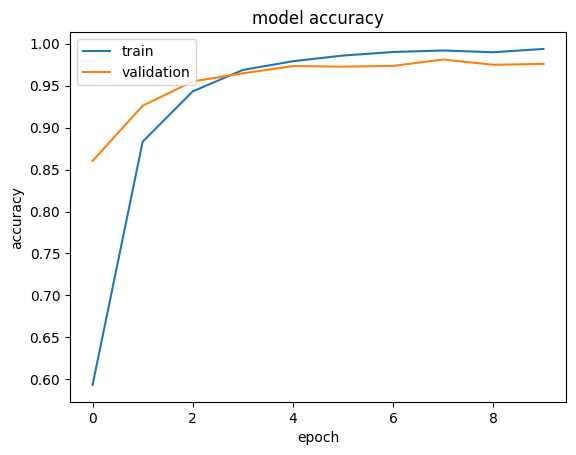

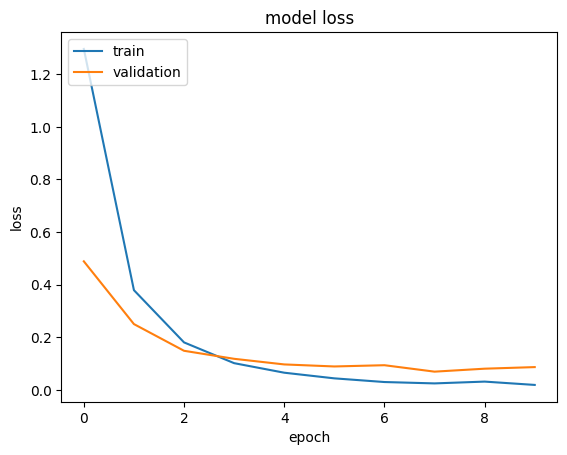

In [14]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

###TASK 1.4 - Testing
Testing the model

Before feeding the neural network, also the test images must be normalized (with values between 0 and 1) and shuffled (in this case the shuffling is only required for visualization purposes), together with their labels. Shuffle the images storing the results in the variables `test_labels` and `test_images`. 
Remember to normalize the samples!!!

In [15]:
################# code here ###################
test_labels = Y_test
test_images = X_test

test_images, test_labels = shuffle(test_images, test_labels, random_state=0)

# Normalization
test_images = test_images / 255.0
################# code here ###################

Definition of the function for the plot of the confusion matrix

In [16]:
def print_confusion_matrix_pandas(model, images, labels):
    num_classes = 13
    # Get the predicted classifications for the test-set.
    predictions = model.predict(images)
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=labels, y_pred=np.argmax(predictions,axis=1))
    cm = cm/cm.sum(axis=0, keepdims=True)
    # Plot the confusion matrix as an image.
    class_names = label_ids.keys()
    df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.axis([-0.5, 13.5, 13.5, -0.5])
    plt.title('Confusion Matrix Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

See the accuracy of the model:

In [17]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

234/234 [==============================] - 3s 11ms/step - loss: 0.5083 - accuracy: 0.9046
Test accuracy: 0.904570460319519


See some results and the confusion matrix of the model

1/1 [==============================] - 0s 331ms/step


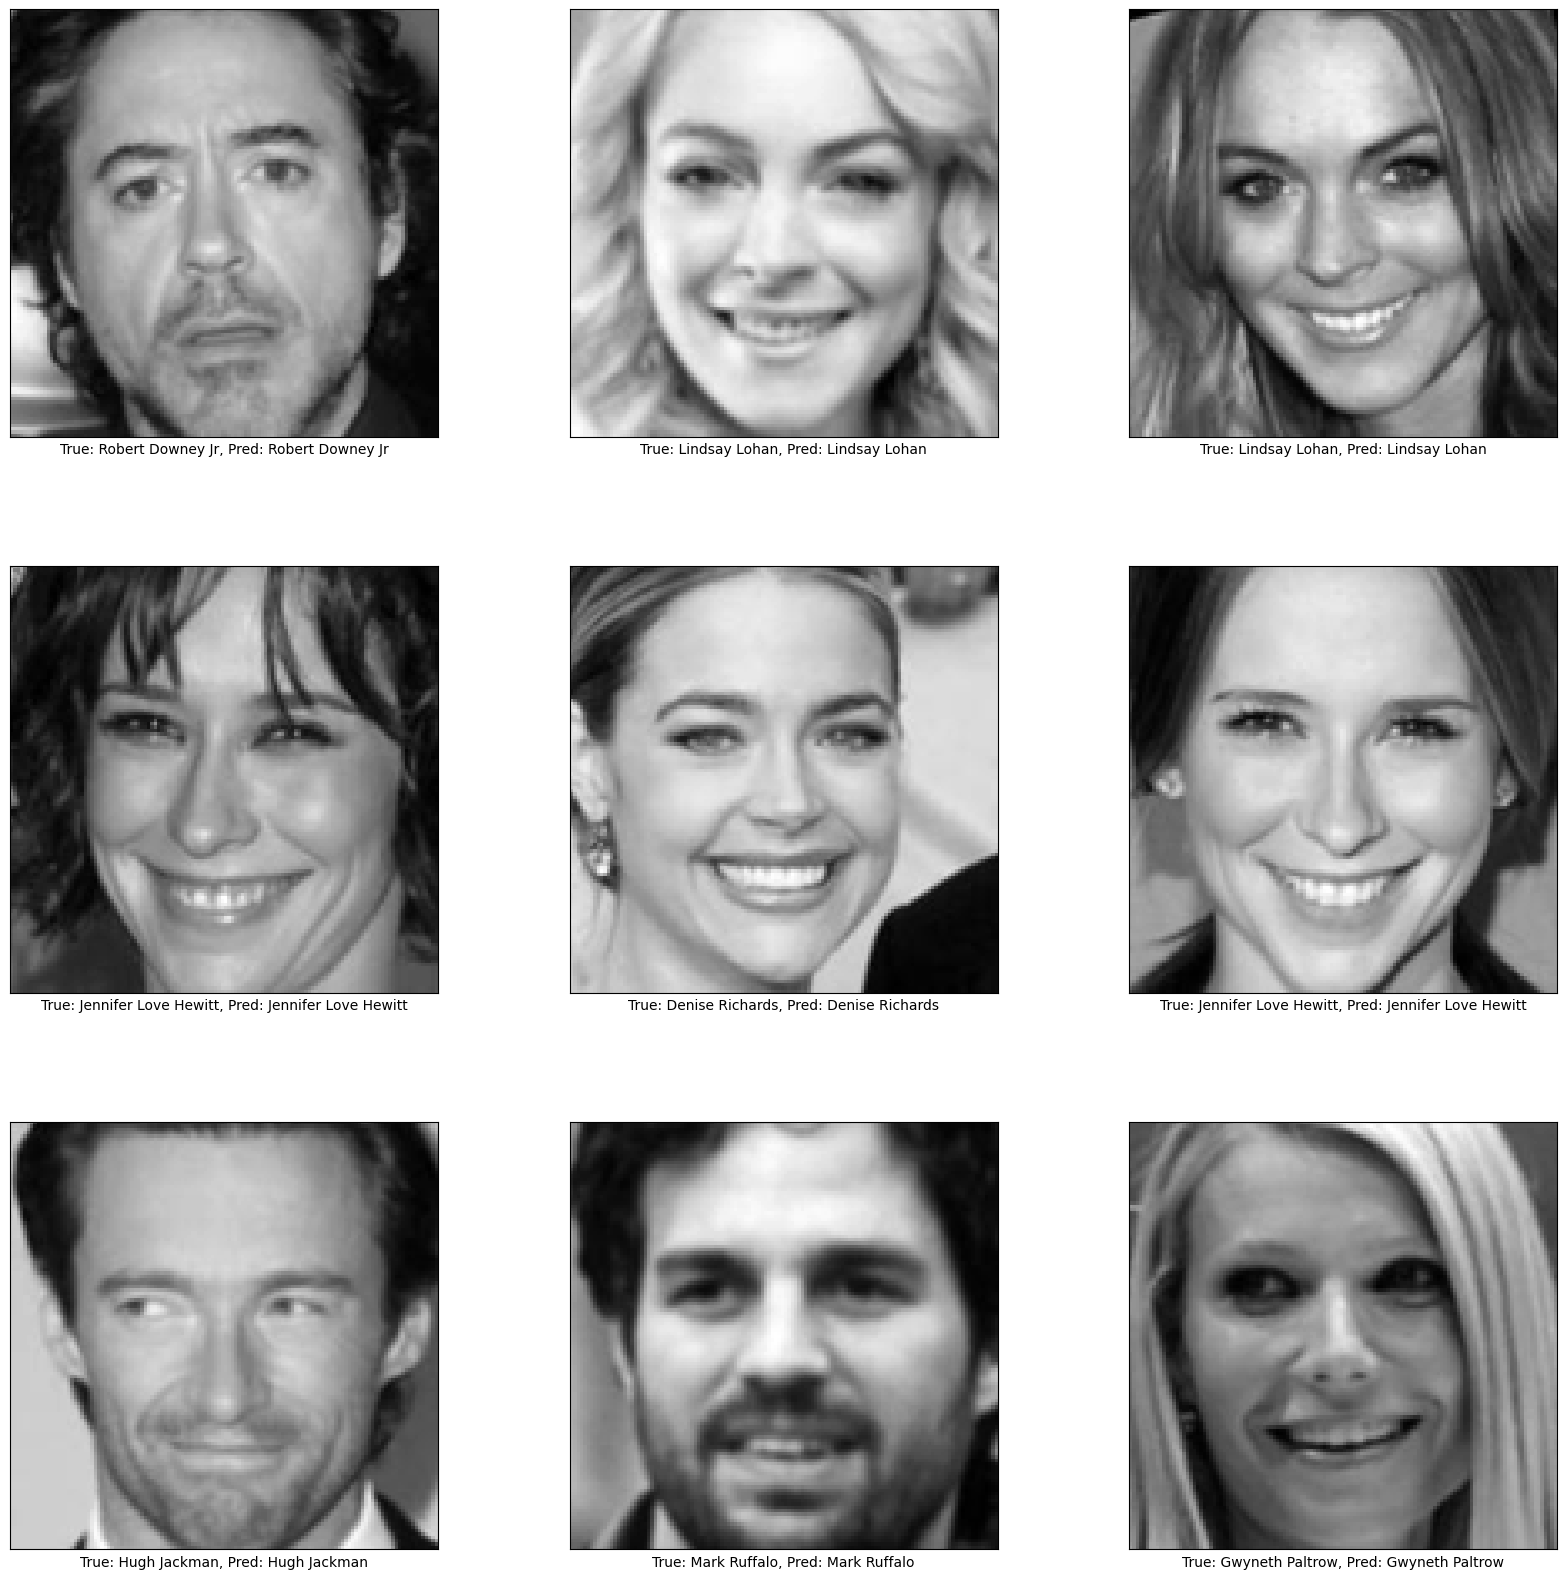

In [18]:
plot_images(test_images[:9], test_labels[:9], model.predict(test_images[:9]), class_names)

234/234 [==============================] - 2s 6ms/step


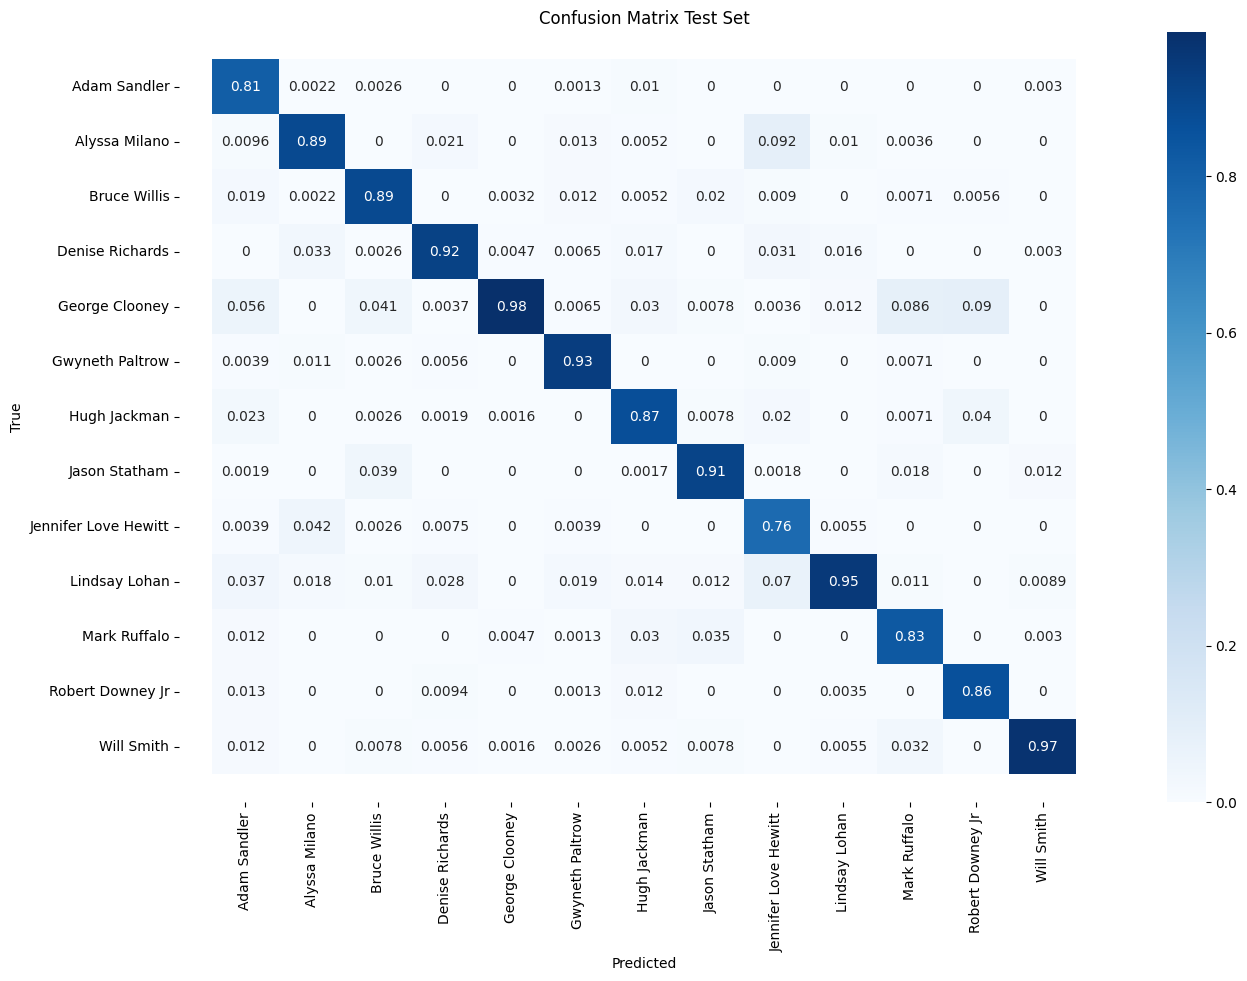

In [19]:
print_confusion_matrix_pandas(model, test_images, test_labels)

### TASK 1.5 - Masked faces
 
Test with masked faces

**Repeat the whole testing procedure** using `X_test_glasses`, `X_test_sunglasses`, `X_test_mask`, `X_test_facemask` instead of `X_test`. What happens? Is the network able to recognize people? What you can do to optimize the recognition of people wearing masks and glasses?

In [20]:
################# code here ###################
#Setting the paths
X_test_glasses_path = './datasets/X_test_glasses.npy'
Y_test_glasses_path = './datasets/Y_test_glasses.npy'
X_test_sunglasses_path = './datasets/X_test_sunglasses.npy'
Y_test_sunglasses_path = './datasets/Y_test_sunglasses.npy'
X_test_mask_path = './datasets/X_test_mask.npy'
Y_test_mask_path = './datasets/Y_test_mask.npy'
X_test_facemask_path = './datasets/X_test_facemask.npy'
Y_test_facemask_path = './datasets/Y_test_facemask.npy'
################# code here ###################

In [21]:
#Initializing data
X_test_glasses = np.load(X_test_glasses_path)
Y_test_glasses = np.load(Y_test_glasses_path)
X_test_sunglasses = np.load(X_test_sunglasses_path)
Y_test_sunglasses = np.load(Y_test_sunglasses_path)
X_test_mask = np.load(X_test_mask_path)
Y_test_mask = np.load(Y_test_mask_path)
X_test_facemask = np.load(X_test_facemask_path)
Y_test_facemask = np.load(Y_test_facemask_path)

231/231 [==============================] - 3s 12ms/step - loss: 0.9530 - accuracy: 0.8188
Test accuracy - Glasses test_set: 0.82
231/231 [==============================] - 2s 8ms/step


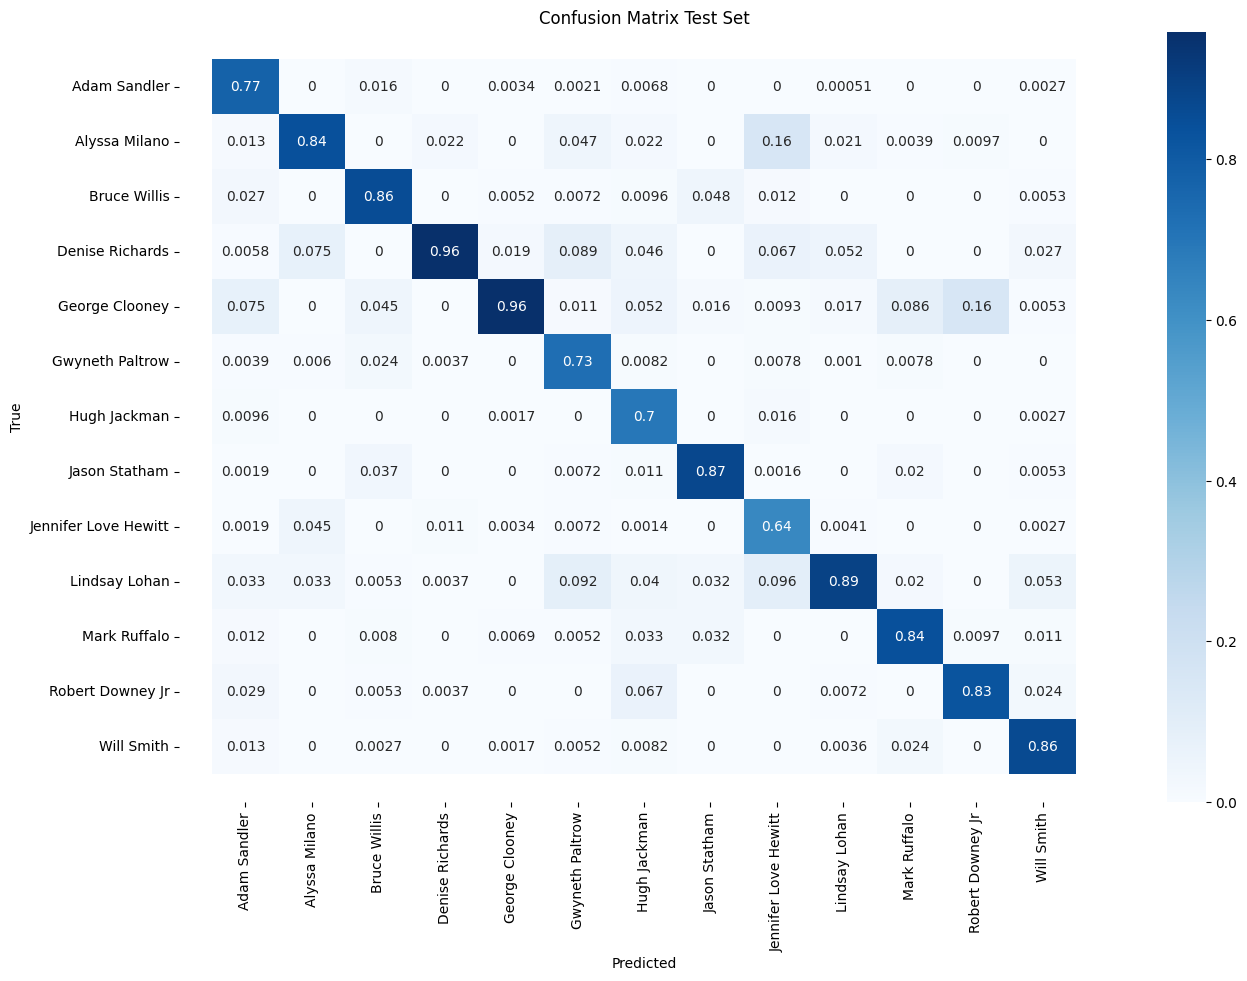

In [22]:
# Case 1: Glasses

# shuffle sets
test_images, test_labels = shuffle(X_test_glasses, Y_test_glasses, random_state = 2057069)

# Normalization
test_images = test_images/255.0

test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Test accuracy - Glasses test_set: %.2f" % (test_acc))

#plotting confusion matrix for Model
print_confusion_matrix_pandas(model, test_images, test_labels)

196/196 [==============================] - 3s 13ms/step - loss: 4.8586 - accuracy: 0.5070
Test accuracy - Sunglasses test_set: 0.51
196/196 [==============================] - 1s 7ms/step


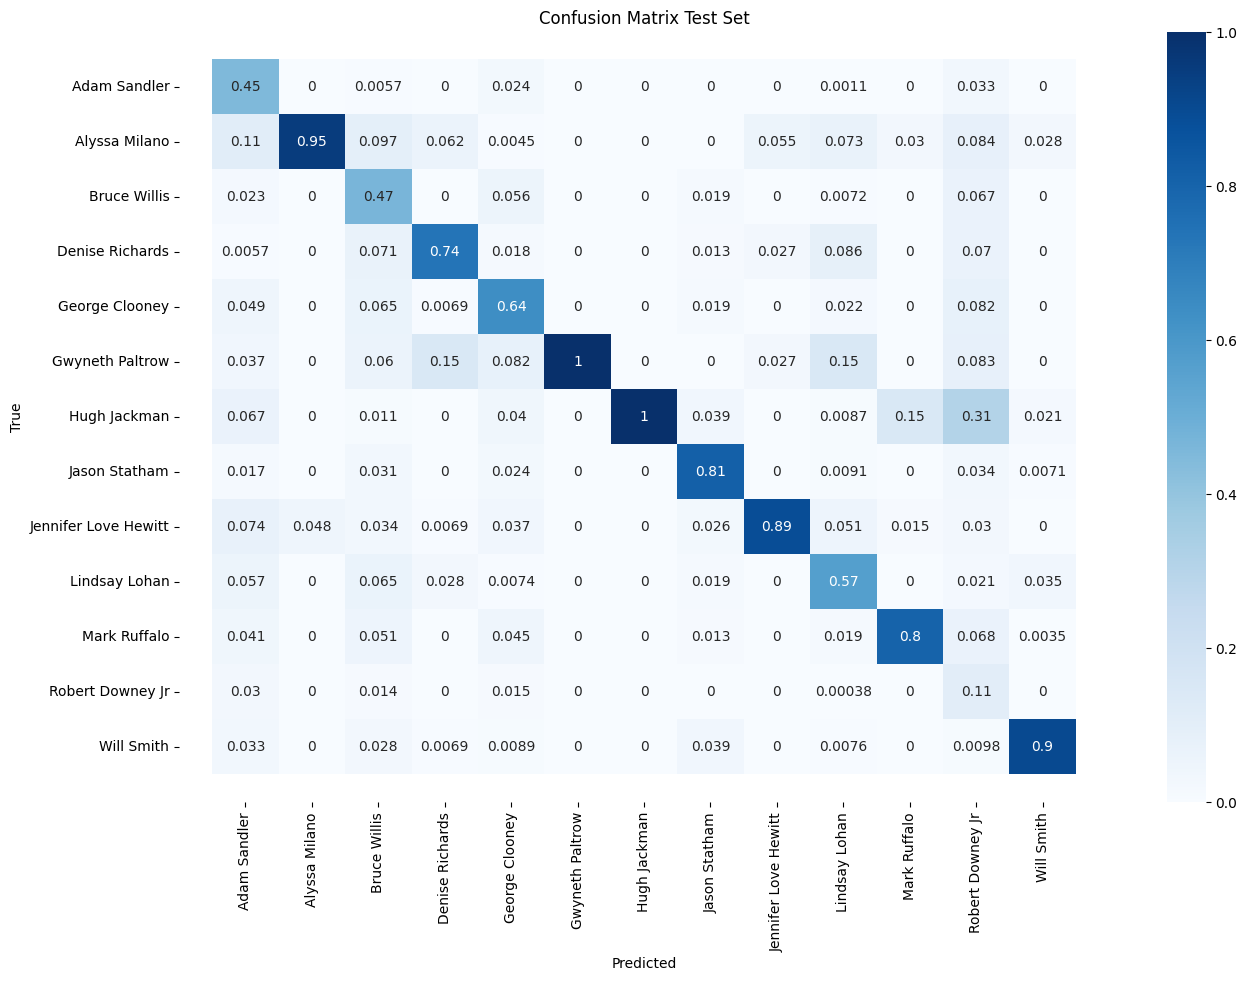

In [23]:
# Case 2: Sunglasses

# shuffle sets
test_images, test_labels = shuffle(X_test_sunglasses, Y_test_sunglasses, random_state = 2057069)

# Normalization
test_images = test_images/255.0

test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Test accuracy - Sunglasses test_set: %.2f" % (test_acc))

#plotting confusion matrix for Model
print_confusion_matrix_pandas(model, test_images, test_labels)

65/65 [==============================] - 1s 16ms/step - loss: 8.4410 - accuracy: 0.4107
Test accuracy - Mask test_set: 0.41
65/65 [==============================] - 0s 3ms/step


<ipython-input-16-ea84ea1c387b>:4: RuntimeWarning: invalid value encountered in true_divide
  predictions = model.predict(images)


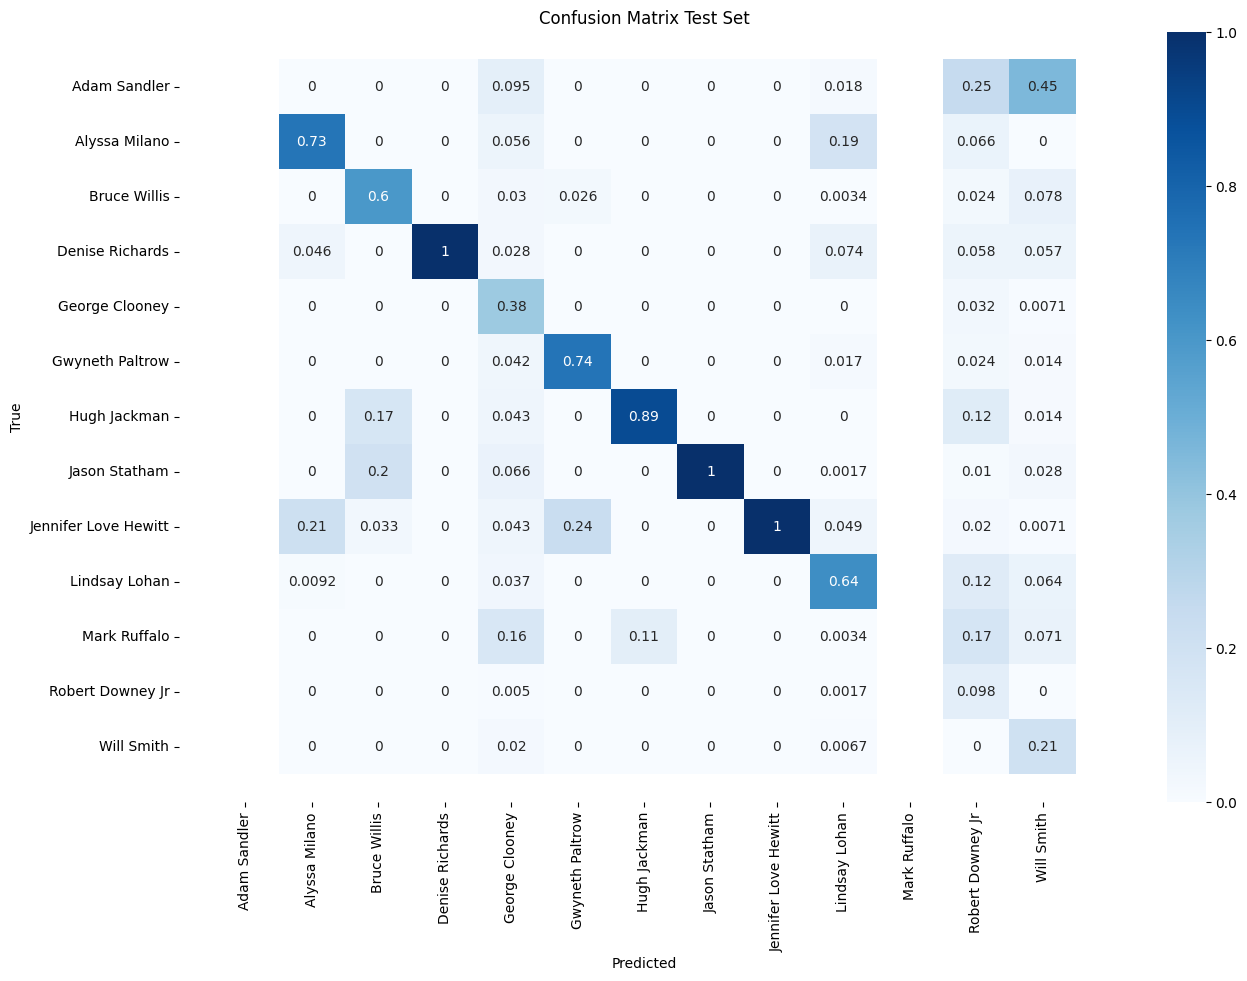

In [24]:
# Case 3: Mask

# shuffle sets
test_images, test_labels = shuffle(X_test_mask, Y_test_mask, random_state = 2057069)

# Normalization
test_images = test_images/255.0

test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Test accuracy - Mask test_set: %.2f" % (test_acc))

#plotting confusion matrix for Model
print_confusion_matrix_pandas(model, test_images, test_labels)

53/53 [==============================] - 1s 26ms/step - loss: 17.8234 - accuracy: 0.2543
Test accuracy - FaceMask test_set: 0.25
53/53 [==============================] - 0s 2ms/step


<ipython-input-16-ea84ea1c387b>:7: RuntimeWarning: invalid value encountered in true_divide
  cm = cm/cm.sum(axis=0, keepdims=True)


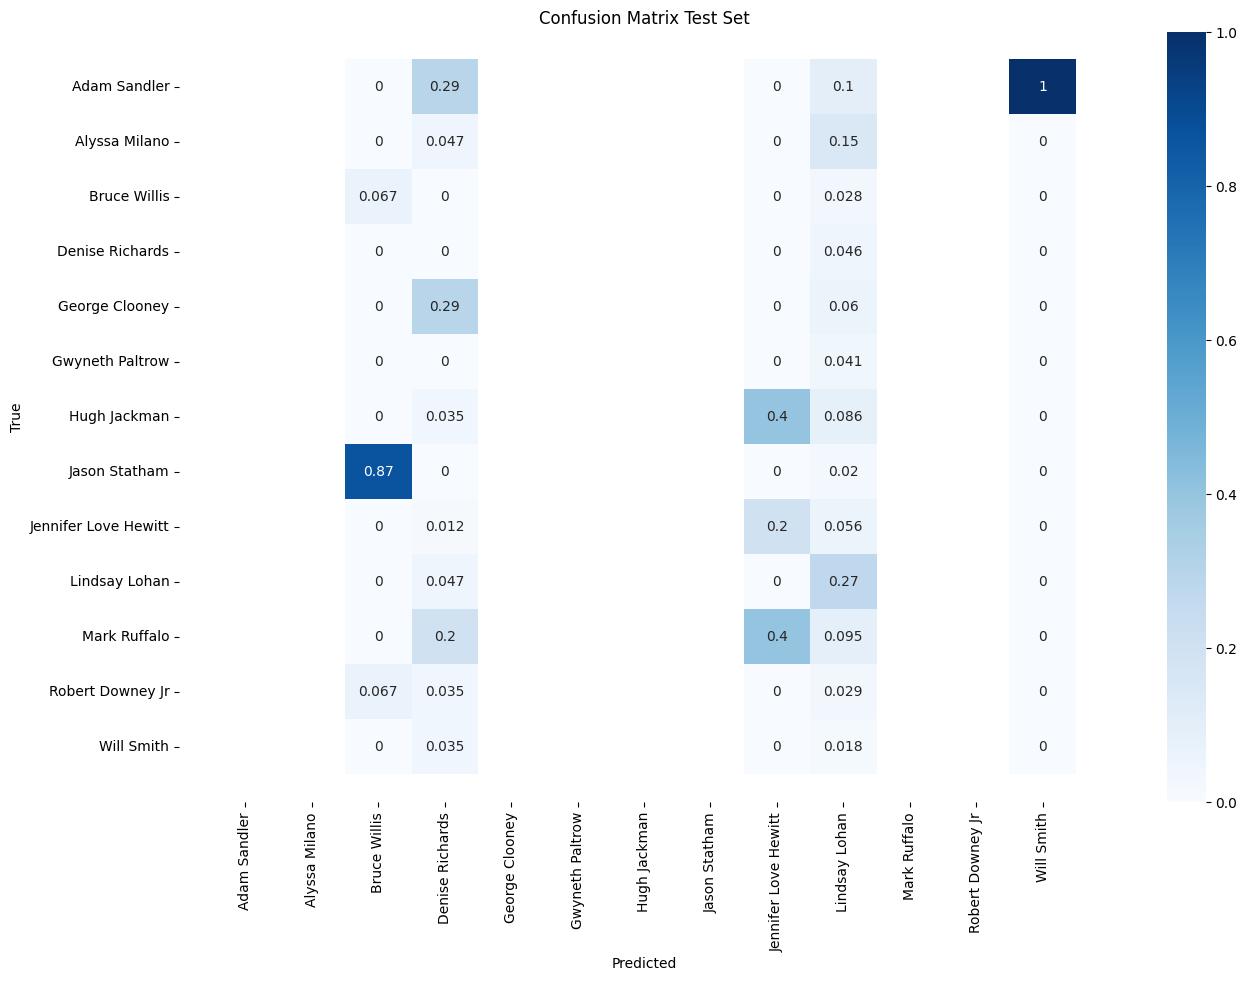

In [25]:
# Case 4: Face Mask

# shuffle sets
test_images, test_labels = shuffle(X_test_facemask, Y_test_facemask, random_state = 2057069)

# Normalization
test_images = test_images/255.0

test_loss, test_acc = model.evaluate(test_images, test_labels)
print("Test accuracy - FaceMask test_set: %.2f" % (test_acc))

#plotting confusion matrix for Model
print_confusion_matrix_pandas(model, test_images, test_labels)

## Section 2: Dataset Stranger Faces



We now load the dataset [Stanger Faces](https://www.kaggle.com/datasets/alirezakay/stranger-things-faces-dataset-grayscale) and prepare the data for the experiment

In [26]:
!gdown https://drive.google.com/uc?id=1v7e84Kgh51aQpb0TkSm2d2DxmnOCNSf5

Downloading...
From: https://drive.google.com/uc?id=1v7e84Kgh51aQpb0TkSm2d2DxmnOCNSf5
To: /content/StrangerFaces.zip
100% 4.90M/4.90M [00:00<00:00, 27.3MB/s]


In [27]:
!unzip StrangerFaces.zip

Archive:  StrangerFaces.zip
   creating: StrangerFaces/
  inflating: StrangerFaces/dataset.npy  
  inflating: StrangerFaces/labels.npy  


In [28]:
X_dataset_path = './StrangerFaces/dataset.npy'
Y_labels_path = './StrangerFaces/labels.npy'

In [29]:
X = np.load(X_dataset_path)
Y = np.load(Y_labels_path)

The faces in this dataset are take from the popular Netflix Show **Stranger Things**.

The characters are:

| Label | Description |
| --- | --- |
| 0 | Eleven |
| 1 | Mike |
| 2 | Will |
| 3 | Dustin |
| 4 | Lucas |
| 5 | Max |
| 6 | Nancy |
| 7 | Jonathan |
| 8 | Steve |
| 9 | Joyce |
| 10 | Jim |

Same as before we prapare our labels

In [30]:
#define the classes
label_ids = {'Eleven': 0, 'Michael Wheeler': 1, 'Will Byers': 2, 'Dustin Henderson': 3, 'Lucas Sinclair': 4, 'Max Mayfield': 5, 'Nancy Wheeler': 6, 'Jonathan Byers': 7, 'Steve Harrington': 8, 'Joyce Byers': 9, 'Jim Hopper': 10}

# Number of classes
num_classes = 11

Let's see some Stranger Faces...

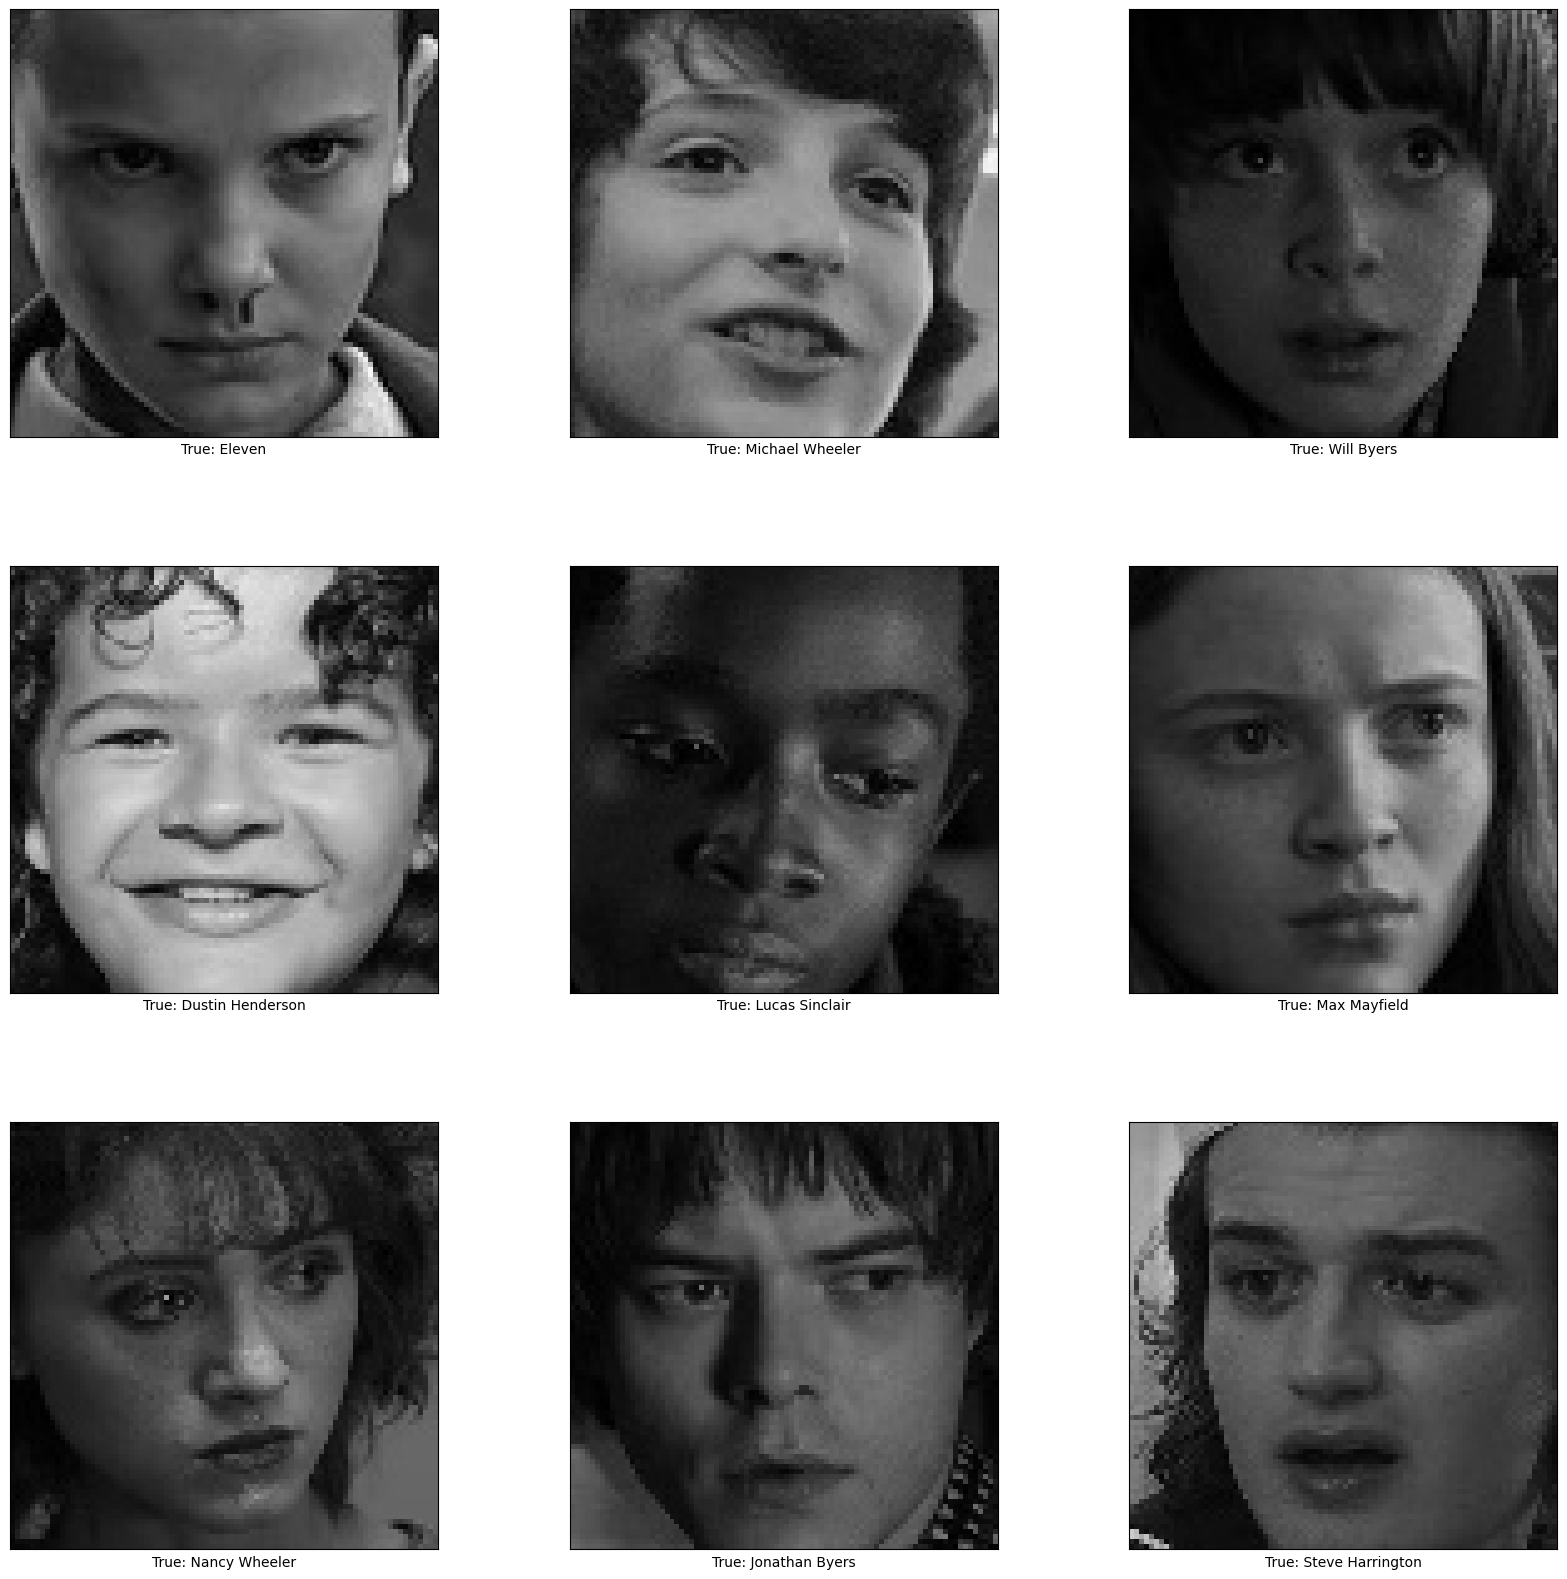

In [31]:
class_names = {value:key for key, value in label_ids.items()}
plot_images(
    X[[3, 118, 186, 250, 320, 390, 400, 460, 500]],
    Y[[3, 118, 186, 250, 320, 390, 400, 460, 500]],
    predictions=None,
    class_names=class_names
)

###TASK 2.1 - Shuffling & Normalization
Shuffling and Normalization of the data

Before feeding the neural network, the images must be normalized (with values between 0 and 1) and shuffled, together with their labels. Shuffle the images storing the results in the variables `train_labels` and `train_images`. Then normalize the images.

In [32]:
################# code here ###################
#shuffle sets using the shuffle function from sklearn (provided above)
X, Y = shuffle(X, Y, random_state=0)

labels = Y
images = X

# Normalization
images = images / 255
################# code here ###################

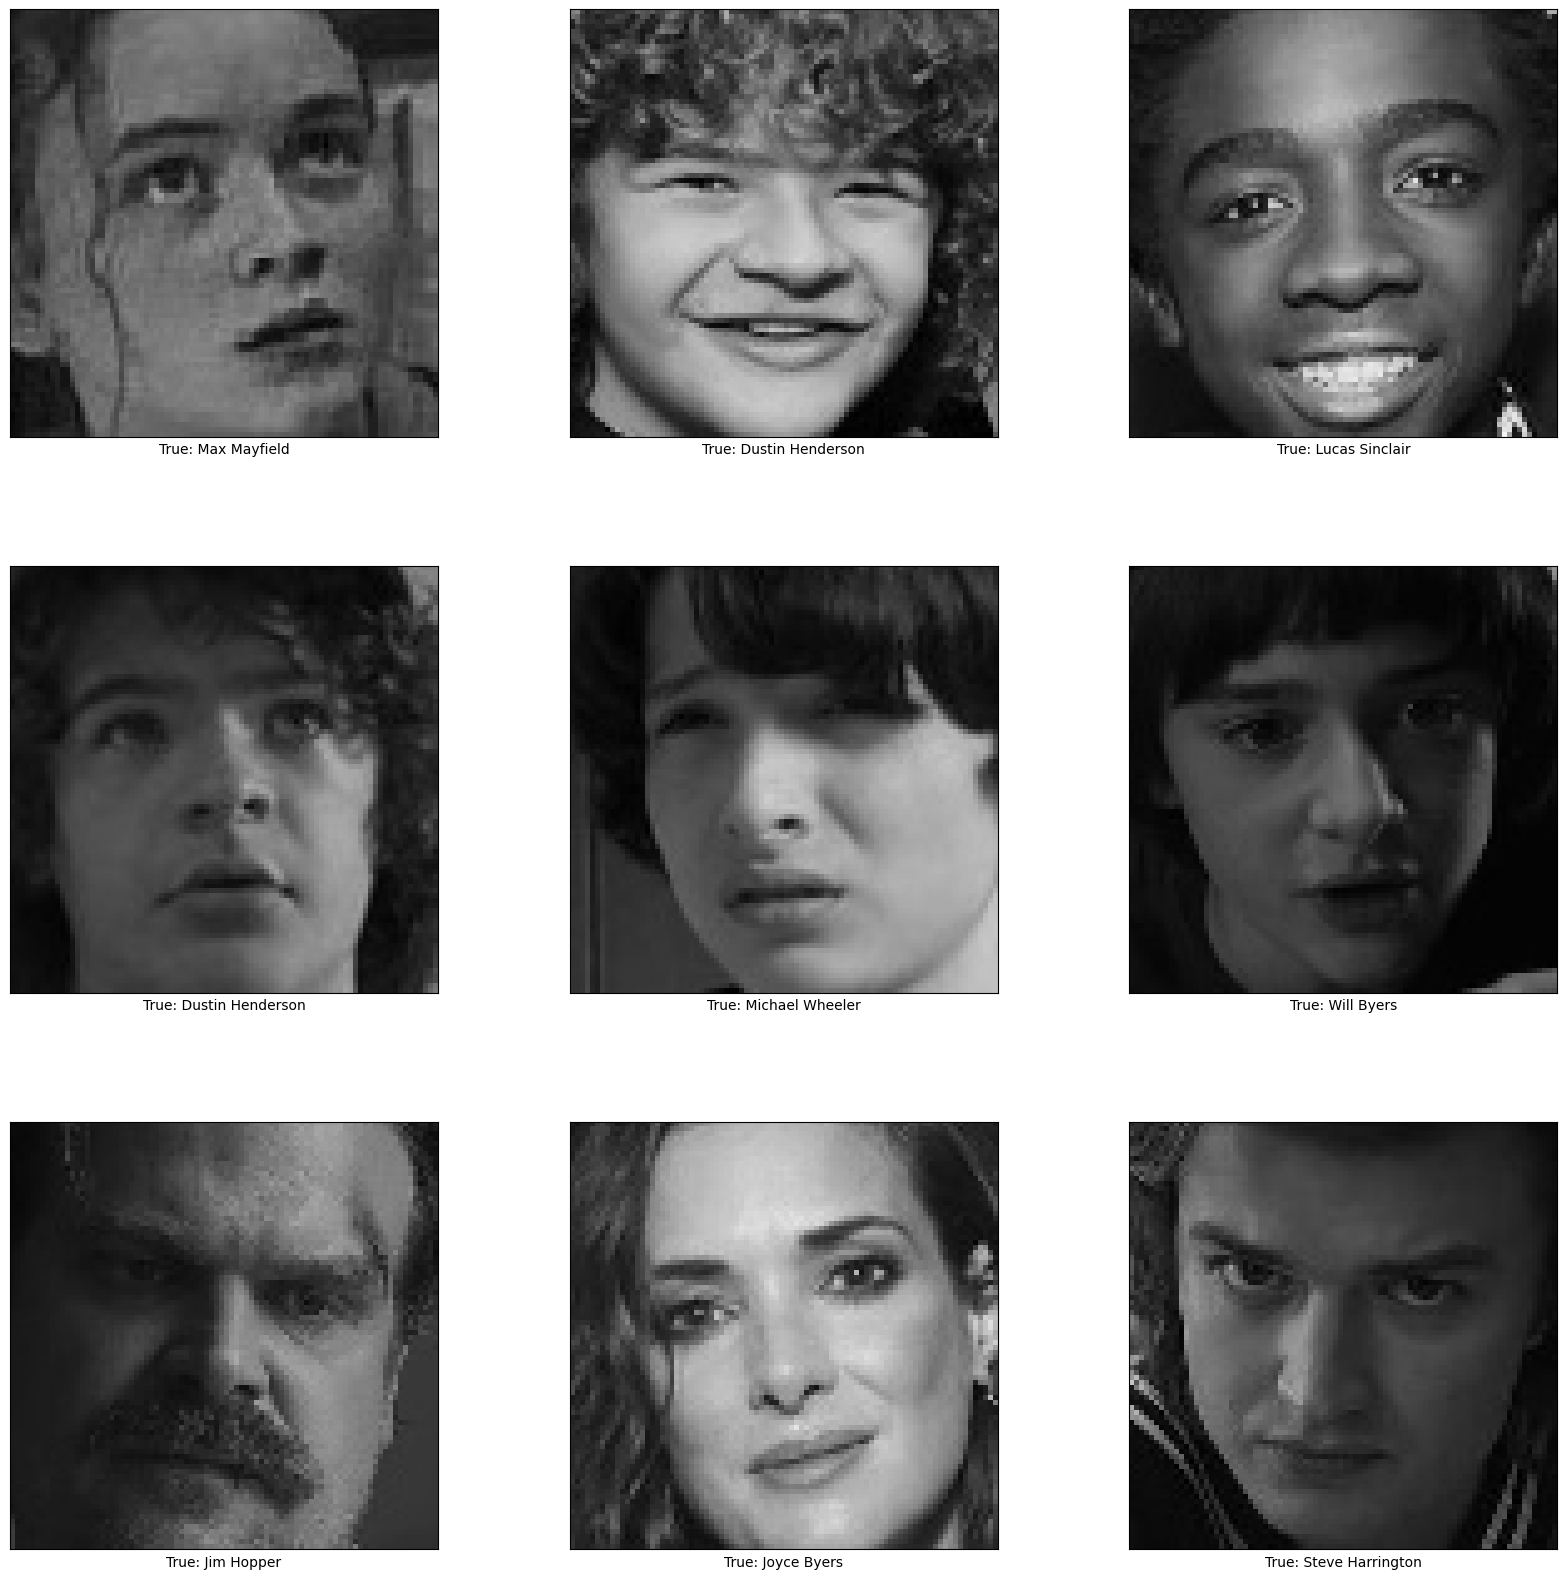

In [33]:
plot_images(
    X[[3, 118, 186, 250, 320, 390, 400, 460, 500]],
    Y[[3, 118, 186, 250, 320, 390, 400, 460, 500]],
    predictions=None,
    class_names=class_names
)

###TASK 2.2 - Pre-trained Model


Use VGG16, but you can see other possible models commented in the next cell

In [34]:
from keras.applications import VGG16 #ResNet50 #ResNet101 #VGG19 #AlexNet #InceptionV3 ...

We build our model which is composed of two blocks:

*   The pretrained model selected
*   One layer for the classification



In [35]:
layer = VGG16(include_top = False, input_shape = (86,86,3))

model = keras.models.Sequential()
model.add(layer)
layer.trainable = False
model.add(Flatten())

#TO DO: Experiment by adding other trainable layers
################# code here ###################

################# code here ###################

model.add(Dense(num_classes, trainable = True))
model.add(Activation('softmax'))

model.build()
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 11)                22539     
                                                                 
 activation (Activation)     (None, 11)                0         
                                                                 
Total params: 14,737,227
Trainable params: 22,539
Non-trainable params: 14,714,688
_________________________________________________________________


In [36]:
model.compile('adam', loss = 'sparse_categorical_crossentropy', metrics='accuracy')

In [37]:
from sklearn.model_selection import train_test_split

x_train_sf, x_test_sf, y_train_sf, y_test_sf = train_test_split(images, labels, test_size = 0.33, shuffle = False)

We now train the last block of the network so that our model learns some usefull weights for the classification of the images in the dataset

In [38]:
history = model.fit(x_train_sf, y_train_sf, batch_size = 32, epochs=20, validation_split = 0.1)

Epoch 1/20
12/12 [==============================] - 8s 527ms/step - loss: 2.3371 - accuracy: 0.1528 - val_loss: 2.2742 - val_accuracy: 0.1905
Epoch 2/20
12/12 [==============================] - 1s 119ms/step - loss: 2.0271 - accuracy: 0.3324 - val_loss: 2.0234 - val_accuracy: 0.3571
Epoch 3/20
12/12 [==============================] - 0s 33ms/step - loss: 1.7974 - accuracy: 0.4799 - val_loss: 1.9285 - val_accuracy: 0.4286
Epoch 4/20
12/12 [==============================] - 0s 43ms/step - loss: 1.6279 - accuracy: 0.5013 - val_loss: 1.8063 - val_accuracy: 0.4286
Epoch 5/20
12/12 [==============================] - 1s 91ms/step - loss: 1.4855 - accuracy: 0.6595 - val_loss: 1.6898 - val_accuracy: 0.5476
Epoch 6/20
12/12 [==============================] - 1s 101ms/step - loss: 1.3660 - accuracy: 0.7158 - val_loss: 1.6189 - val_accuracy: 0.5476
Epoch 7/20
12/12 [==============================] - 0s 33ms/step - loss: 1.2693 - accuracy: 0.6917 - val_loss: 1.5623 - val_accuracy: 0.5952
Epoch 8/20

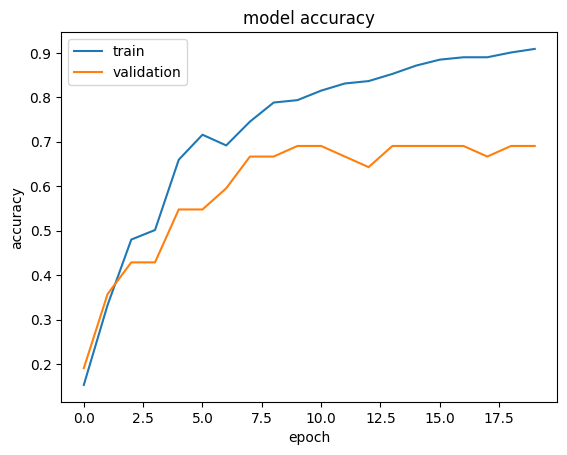

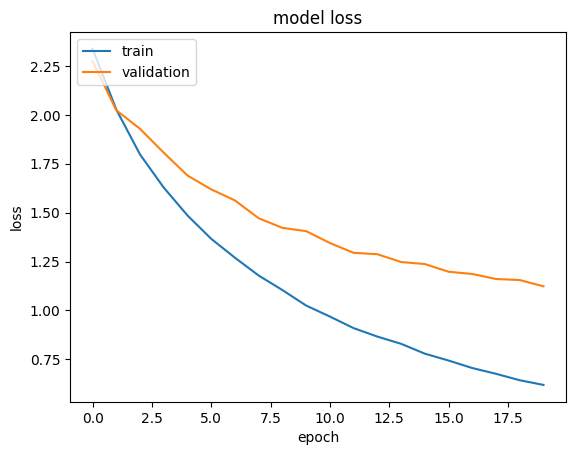

In [39]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [40]:
test_loss, test_acc = model.evaluate(x_test_sf, y_test_sf)
print('Test accuracy:', test_acc)

7/7 [==============================] - 2s 346ms/step - loss: 1.0630 - accuracy: 0.6829
Test accuracy: 0.6829268336296082


In [41]:
def print_confusion_matrix_pandas(model, images, labels):
    num_classes = 11
    # Get the predicted classifications for the test-set.
    predictions = model.predict(images)
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=labels, y_pred=np.argmax(predictions,axis=1))
    cm = cm/cm.sum(axis=0, keepdims=True)
    # Plot the confusion matrix as an image.
    class_names = label_ids.keys()
    df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.axis([-0.5, 11.5, 11.5, -0.5])
    plt.title('Confusion Matrix Test Set')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    return predictions

7/7 [==============================] - 0s 30ms/step


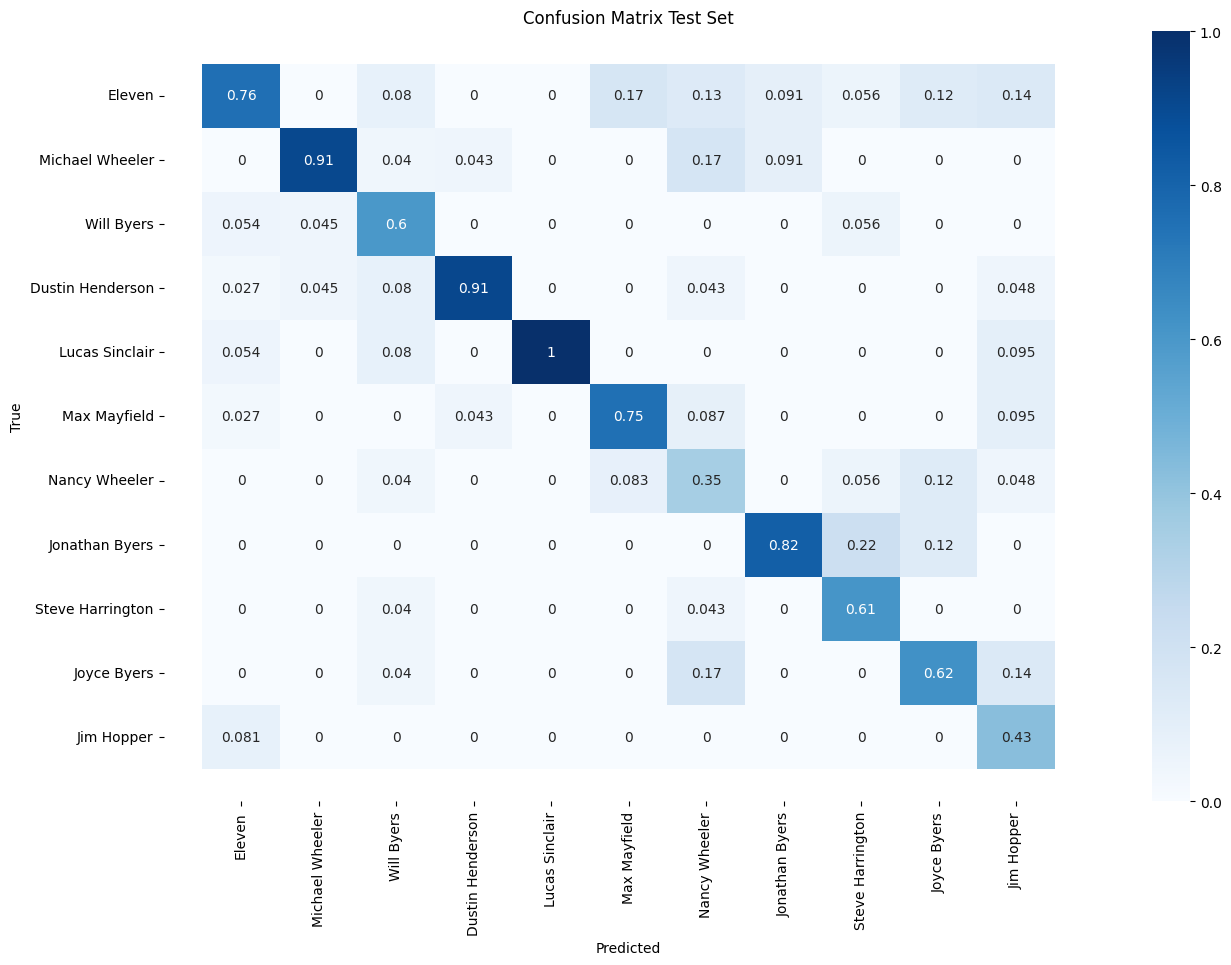

In [42]:
predictions = print_confusion_matrix_pandas(model, x_test_sf, y_test_sf)